# Best Models Comparison

Input: single principal component with PCA for 15 indicators + returns

Output: optimal max-shape portfolio with tight restrictions for the next period

In [1]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv1D, Dropout, Bidirectional, GRU
from keras.regularizers import L2

from sklearn.ensemble import RandomForestRegressor

from helper_functions import train_and_evaluate_model, run_full_backtesting

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [15]:
data_provider = DataProvider()
y = data_provider.get_formatted_targets()

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Selected best performing models

In [38]:
x_7_months_flatten = data_provider.get_formatted_features(no_months=7, flatten=True)
(x_train_7_months_flatten, y_train, x_val_7_months_flatten, y_val, 
 x_test_7_months_flatten, y_test) = data_provider.train_train_split(x_7_months_flatten, y)

In [41]:
dnn_model = Sequential((
    Input(shape=x_train_7_months_flatten.shape[1:]),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(dnn_model, x_train_7_months_flatten, y_train,
                         x_val_7_months_flatten, y_val, 
                         x_test_7_months_flatten, y_test, verbose=False)

Train error: 7.461182394763455e-05
Val error: 0.0007843468338251114
Test error: 0.0027721566148102283
Execution time 9.03 seconds


In [26]:
x_7_months = data_provider.get_formatted_features(no_months=7)
(x_train_7_months, y_train, x_val_7_months, y_val, 
 x_test_7_months, y_test) = data_provider.train_train_split(x_7_months, y)

In [29]:
cnn_model = Sequential((
    Input(shape=x_train_7_months.shape[1:]),
    Conv1D(32, 3),
    Flatten(),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(cnn_model, x_train_7_months, y_train,
                         x_val_7_months, y_val, 
                         x_test_7_months, y_test, verbose=False)

Train error: 0.0004677690449170768
Val error: 0.0006080055609345436
Test error: 0.0009997128508985043
Execution time 9.03 seconds


In [20]:
x_9_months = data_provider.get_formatted_features(no_months=9)
x_train_9_months, y_train, x_val_9_months, y_val, x_test_9_months, y_test = data_provider.train_train_split(x_9_months, y)

In [21]:
bidirectional_model = Sequential((
    Input(shape=x_train_9_months.shape[1:]),
    Bidirectional(layer=GRU(16, return_sequences=True),
                    backward_layer=GRU(16, activation='relu',
                        return_sequences=True,
                        go_backwards=True)),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(bidirectional_model, x_train_9_months, y_train,
                         x_val_9_months, y_val, 
                         x_test_9_months, y_test, verbose=False)

Train error: 0.00043833800009451807
Val error: 0.0005550170317292213
Test error: 0.0010429947869852185
Execution time 11.52 seconds


In [22]:
x_9_months_flatten = data_provider.get_formatted_features(no_months=9, flatten=True)
(x_train_9_months_flatten, y_train, _, _,
 x_test_9_months_flatten, y_test) = data_provider.train_train_split(x_9_months_flatten, y, with_val=False)

In [23]:
random_forest = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                                      min_samples_split=6, n_estimators=50, random_state=42)

random_forest.fit(x_train_9_months_flatten, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=50, random_state=42)

## Backtesting

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


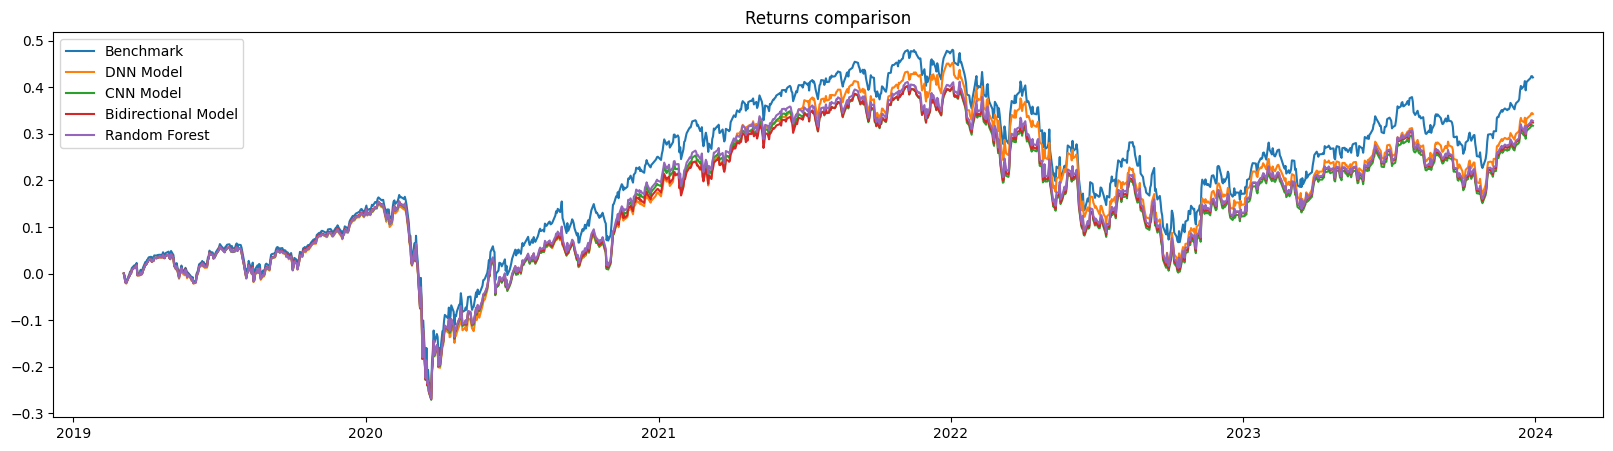

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
DNN Model,0.063667,0.202781,0.31397,0.365038,-0.364962,499.0,0.174449,-0.34746
CNN Model,0.059488,0.201607,0.295067,0.34213,-0.367364,538.0,0.161931,-0.638754
Bidirectional Model,0.060619,0.201635,0.300638,0.348385,-0.367526,493.0,0.164938,-0.606432
Random Forest,0.061191,0.202204,0.302619,0.351923,-0.366006,493.0,0.167185,-0.599576


In [42]:
models_with_data = {
    'DNN Model': (dnn_model, x_test_7_months_flatten),
    'CNN Model': (cnn_model, x_test_7_months),
    'Bidirectional Model': (bidirectional_model, x_test_9_months),
    'Random Forest': (random_forest, x_test_9_months_flatten)
}

df_results = run_full_backtesting(data_provider, models_with_data)
df_results